In [11]:
import os
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory

# Define the path to the dataset
dataset_path = r"D:\Pattern_Recognition\realwaste\realwaste-main\RealWaste"

# Define classes
classes = ["Cardboard", "Food Organics", "Glass", "Metal", "Miscellaneous Trash", "Paper", "Plastic", "Textile Trash", "Vegetation"]
class_paths = {cls: os.path.join(dataset_path, cls) for cls in classes}
class_paths

{'Cardboard': 'D:\\Pattern_Recognition\\realwaste\\realwaste-main\\RealWaste\\Cardboard',
 'Food Organics': 'D:\\Pattern_Recognition\\realwaste\\realwaste-main\\RealWaste\\Food Organics',
 'Glass': 'D:\\Pattern_Recognition\\realwaste\\realwaste-main\\RealWaste\\Glass',
 'Metal': 'D:\\Pattern_Recognition\\realwaste\\realwaste-main\\RealWaste\\Metal',
 'Miscellaneous Trash': 'D:\\Pattern_Recognition\\realwaste\\realwaste-main\\RealWaste\\Miscellaneous Trash',
 'Paper': 'D:\\Pattern_Recognition\\realwaste\\realwaste-main\\RealWaste\\Paper',
 'Plastic': 'D:\\Pattern_Recognition\\realwaste\\realwaste-main\\RealWaste\\Plastic',
 'Textile Trash': 'D:\\Pattern_Recognition\\realwaste\\realwaste-main\\RealWaste\\Textile Trash',
 'Vegetation': 'D:\\Pattern_Recognition\\realwaste\\realwaste-main\\RealWaste\\Vegetation'}

In [12]:
image_directory = r"D:\Pattern_Recognition\realwaste\realwaste-main\RealWaste"

# Load the dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    image_directory,
    labels="inferred",        # Infer labels from folder names
    label_mode="int",         # Integer encoding of labels
    batch_size=32,            # Number of images per batch
    image_size=(224, 224),    # Resize images to 224x224
    shuffle=True              # Shuffle the dataset
)

# Display class names
class_names = train_dataset.class_names
print("Classes:", class_names)

# Inspect a batch of images and labels
for images, labels in train_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")

Found 4752 files belonging to 9 classes.
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [22]:
# Load training and validation datasets
train_dataset = image_dataset_from_directory(
    image_directory,
    labels="inferred",        # Infer labels from folder names
    label_mode="int",         # Integer encoding of labels
    batch_size=32,            # Number of images per batch
    image_size=(224, 224),      # Resize images to 28x28 (MNIST input size)
    shuffle=True,             # Shuffle the dataset
    validation_split=0.4,     # Use 20% of data for validation
    subset="training",        # Load the training subset
    seed=123                  # Set a seed for reproducibility
)

val_test_dataset = image_dataset_from_directory(
    image_directory,
    labels="inferred",
    label_mode="int",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.4,
    subset="validation",
    seed=123
)

# Step 2: Split validation+testing into 20% validation and 20% testing
val_size = len(val_test_dataset) // 2
val_dataset = val_test_dataset.take(val_size)  # First half for validation
test_dataset = val_test_dataset.skip(val_size)  # Second half for testing

normalization_layer = tf.keras.layers.Rescaling(1./255)

train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Check dataset sizes (optional)
print(f"Training dataset size: {len(train_dataset)} batches")
print(f"Validation dataset size: {len(val_dataset)} batches")
print(f"Testing dataset size: {len(test_dataset)} batches")

Found 4752 files belonging to 9 classes.
Using 2852 files for training.
Found 4752 files belonging to 9 classes.
Using 1900 files for validation.
Training dataset size: 90 batches
Validation dataset size: 30 batches
Testing dataset size: 30 batches


In [23]:
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet

# Load DenseNet121 pre-trained on ImageNet without the top (classification) layer
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layers of DenseNet
for layer in densenet_model.layers:
    layer.trainable = False

# Add custom layers for fine-tuning DenseNet
densenet_model_out = layers.GlobalAveragePooling2D()(densenet_model.output)
densenet_model_out = layers.Dense(128, activation='relu')(densenet_model_out)
densenet_model_out = layers.Dense(9, activation='softmax')(densenet_model_out)

# Create the DenseNet-based model
densenet_model = models.Model(inputs=densenet_model.input, outputs=densenet_model_out)


In [24]:
# Compile the DenseNet-based model
densenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_densenet = densenet_model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10
90/90 [==============================] - 230s 2s/step - loss: 1.1532 - accuracy: 0.5978 - val_loss: 0.8602 - val_accuracy: 0.6938
Epoch 2/10
90/90 [==============================] - 227s 3s/step - loss: 0.6447 - accuracy: 0.7742 - val_loss: 0.7610 - val_accuracy: 0.7354
Epoch 3/10
90/90 [==============================] - 224s 2s/step - loss: 0.5018 - accuracy: 0.8229 - val_loss: 0.7393 - val_accuracy: 0.7292
Epoch 4/10
90/90 [==============================] - 222s 2s/step - loss: 0.4274 - accuracy: 0.8604 - val_loss: 0.6803 - val_accuracy: 0.7729
Epoch 5/10
90/90 [==============================] - 231s 3s/step - loss: 0.3582 - accuracy: 0.8766 - val_loss: 0.7037 - val_accuracy: 0.7500
Epoch 6/10
90/90 [==============================] - 238s 3s/step - loss: 0.3093 - accuracy: 0.9011 - val_loss: 0.6162 - val_accuracy: 0.7854
Epoch 7/10
90/90 [==============================] - 259s 3s/step - loss: 0.2459 - accuracy: 0.9295 - val_loss: 0.6324 - val_accuracy: 0.7865
Epoch 8/10
90

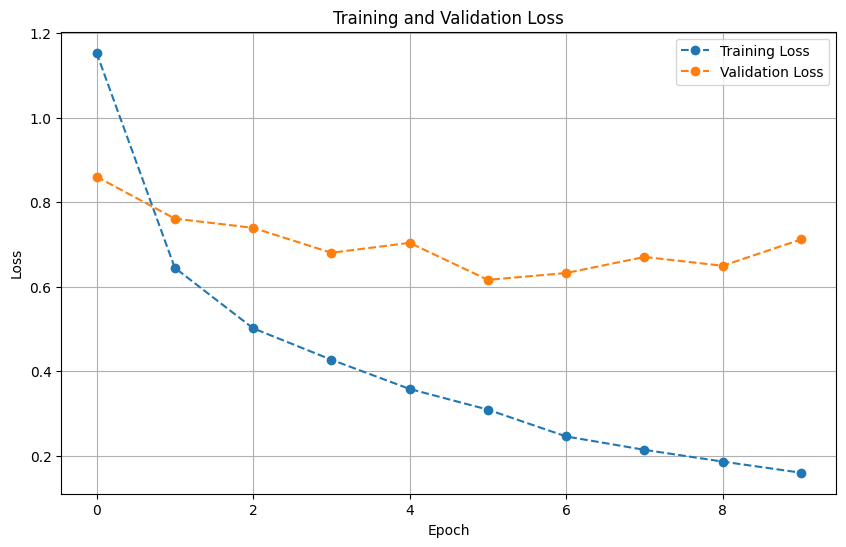

In [25]:
import matplotlib.pyplot as plt
# Plot training, validation, and testing loss with respect to epochs
plt.figure(figsize=(10, 6))
plt.plot(history_densenet.history['loss'], label='Training Loss', linestyle='--', marker='o')
plt.plot(history_densenet.history['val_loss'], label='Validation Loss', linestyle='--', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
# Evaluate the model on the test data and collect test loss
test_loss, test_acc = densenet_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

30/30 [==============================] - 53s 2s/step - loss: 0.6349 - accuracy: 0.7979
Test Loss: 0.6348757743835449
Test Accuracy: 0.7978723645210266
